In [63]:
import os
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

In [64]:
# Global Variables
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

In [65]:
# Paths: For local machine
train_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/train'
validation_dir = 'C:/Users/Nick/Documents/SchoolStuff/spring2024/machineLearning/final_project/tradingpatterns/stock_patterns/validation'

# Create training and validation dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 16000 files belonging to 8 classes.
Found 16000 files belonging to 8 classes.


In [66]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [67]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [68]:
# This feature extractor converts each 255x255 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [69]:
base_model.trainable = False

# Adding a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [83]:
# Add a dense layer to convert it to a single prediction per image
# Test relu, leaky_relu, and sigmoid
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(128, 128, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# We use binary accuracy here because of the Sigmoid?
# If we use a different activator then I am not sure 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [84]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

400/400 ━━━━━━━━━━━━━━━━━━━━ 101s 248ms/step - accuracy: 0.1261 - loss: 2.0480


In [60]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 220s 431ms/step - accuracy: 0.1267 - loss: -21.0735 - val_accuracy: 0.1250 - val_loss: -39.6517
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 215s 431ms/step - accuracy: 0.1273 - loss: -37.6078 - val_accuracy: 0.1250 - val_loss: -39.6517
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 216s 432ms/step - accuracy: 0.1274 - loss: -38.4647 - val_accuracy: 0.1250 - val_loss: -39.6517
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 217s 434ms/step - accuracy: 0.1273 - loss: -38.6367 - val_accuracy: 0.1250 - val_loss: -39.6517
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 214s 429ms/step - accuracy: 0.1273 - loss: -39.0507 - val_accuracy: 0.1250 - val_loss: -39.6517
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 204s 409ms/step - accuracy: 0.1273 - loss: -39.3146 - val_accuracy: 0.1250 - val_loss: -39.6517
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 206s 412ms/step - accuracy: 0.1273 - loss: -39.4026 - val_accuracy: 0.1250 - val_loss: -39.6517
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 206s 413

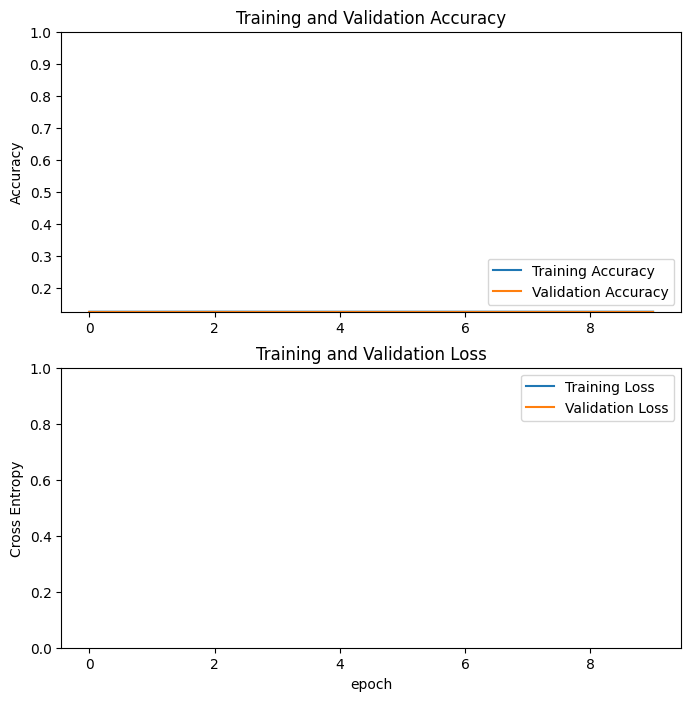

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)